In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))

2.5.1+cu124
True
NVIDIA GeForce RTX 3080 Ti


In [ ]:
'''
To run this file on google colab, you need to run the code in this section to prepare the environment.

!pip uninstall torch torchvision torchaudio
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
!pip install -U bitsandbytes
!pip install trl

import os
os._exit(00)

'''

In [2]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import bitsandbytes as bnb
import numpy as np

#from Dataloader import EventPairDataset

c:\Users\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
special_tokens = ["<TRG>", "</TRG>", "<ARG>", "</ARG>", "<TIME>", "</TIME>", "<LOC>", "</LOC>"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "meta-llama/Llama-3.2-1B"
hf_auth = '' #enter your huggingface authentication token here

In [ ]:
from pathlib import Path

train_data_path = Path('C:/Users/OG/Desktop/Midterm/Midterm/Data/train_srl.json')
dev_data_path = Path('C:/Users/OG/Desktop/Midterm/Midterm/Data/dev_srl.json')
test_data_path = Path('C:/Users/OG/Desktop/Midterm/Midterm/Data/test_srl.json')

In [5]:
# Model parameters
batch_size = 32
learning_rate = 2e-5
epochs = 1

In [6]:
# quatization parameters
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype='bfloat16'
)

In [7]:
# lora parameters
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

In [3]:
#Does the events mentioned in the following two sentences refer to the same event? Answer strictly "Yes" or "No" 2
#Does the following two sentences mention the same event? Answer strictly "Yes" or "No" 1
#Does the events mentioned in the following two sentences refer to the same event? 3
#Does the following two sentences mention the same event? Only answer Yes or No.4


def prompt_format(instance, include_answer=True):
    prompt = (
        f'Question: Does the following two sentences mention the same event? Only answer Yes or No.\n'
        f'Sentence 1: {instance["sentence1"]}\n'
        f'Sentence 2: {instance["sentence2"]}\n'
        f'Answer: '
    )
    if include_answer:
        answer = 'Yes' if instance['label'] == 1 else 'No'
        prompt += answer
    return prompt

In [4]:
def load_eval_data_with_prompt(data, path=True):
    if path:
        with open(data, 'r') as file:
            dataset = json.load(file)
    else:
        dataset = data
    data_with_prompt = [prompt_format(instance, include_answer=False) for instance in dataset]

    answer = [instance['label'] for instance in dataset]
    return data_with_prompt, answer


In [13]:
def evaluation(y_pred, y_true):
    labels = [0, 1] 
    
    confusion_m = confusion_matrix(y_true, y_pred, labels=labels)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Confusion Matrix: {confusion_m}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'Support: {support}')
    print(f'Accuracy: {accuracy}')
    print(f'Macro Precision: {precision.mean()}')
    print(f'Macro Recall: {recall.mean()}')
    print(f'Macro F1: {f1.mean()}')


***Start Processing***

In [10]:
# load Trian Data
'''
train = EventPairDataset(train_data_path, srl=False)

train_dataset = Dataset.from_dict(train.data)
'''

# For srl data, you can load the pre-processed srl file to save time, or set srl=True to process the data.
with open(train_data_path, 'r') as file:
    train_dataset = Dataset.from_list(json.load(file))

In [9]:
# create no-answer prompts for dev and test data
# load with pre-processed srl file
dev_data_with_prompt, dev_answer = load_eval_data_with_prompt(dev_data_path, path=True)
test_data_with_prompt, test_answer = load_eval_data_with_prompt(test_data_path, path=True)

'''
# load with unprocessed file
dev = EventPairDataset(dev_data_path, srl=False)
test = EventPairDataset(test_data_path, srl=False, test=True)
dev_data_with_prompt, dev_answer = load_eval_data_with_prompt(dev.data, path=False)
test_data_with_prompt, test_answer = load_eval_data_with_prompt(test.data, path=False)
'''

'\n# load with unprocessed file\ndev = EventPairDataset(dev_data_path, srl=False)\ntest = EventPairDataset(test_data_path, srl=False, test=True)\ndev_data_with_prompt, dev_answer = load_eval_data_with_prompt(dev.data, path=False)\ntest_data_with_prompt, test_answer = load_eval_data_with_prompt(test.data, path=False)\n'

In [13]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=False,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    token=hf_auth
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})

8

In [13]:
# load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    quantization_config=quantization_config,
    token=hf_auth
)

# add special tokens and resize the token embeddings
model.resize_token_embeddings(len(tokenizer))
embedding_layer = model.get_input_embeddings()
special_tokens_ids = tokenizer.convert_tokens_to_ids(special_tokens)
with torch.no_grad():
    for token_id in special_tokens_ids:
        embedding_layer.weight[token_id] = torch.mean(embedding_layer.weight, dim=0)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [14]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    peft_config=lora_config,
    formatting_func=prompt_format,
    args=SFTConfig(
        output_dir='llama_coref_lora2',
        max_seq_length=256,
        packing=True,
        bf16=True,
        save_strategy="steps",
        save_steps=200,
        learning_rate=learning_rate,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs = {'use_reentrant': True},
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
    )
)

C:\Users\OG\AppData\Local\Temp\ipykernel_22480\3945679906.py:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
Packing train dataset: 100%|██████████| 59649/59649 [00:07<00:00, 7590.24 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [15]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
500,3.071700


c:\Users\nlp\lib\site-packages\peft\utils\other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-67ce036d-7a5776154a1756d926693e4c;cbe29f81-fcff-44ad-b855-6f0991366281)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-1B.
  warnings.warn(
c:\Users\nlp\lib\site-packages\peft\utils\save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-1B - will assume that the vocabulary was not modified.
  warnings.warn(
c:\Users\nlp\lib\site-packages\peft\utils\other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-67ce08c7-07e424ee4c72e443015e830c;4838344c-2f26-42c7-b2e0-6707

TrainOutput(global_step=961, training_loss=2.9070774360204212, metrics={'train_runtime': 6601.9847, 'train_samples_per_second': 4.655, 'train_steps_per_second': 0.146, 'total_flos': 4.595534451022234e+16, 'train_loss': 2.9070774360204212})

In [49]:
torch.cuda.empty_cache()

***Evaluation***

In [14]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    quantization_config=quantization_config,
    token=hf_auth
)

# add special tokens and resize the token embeddings
base_model.resize_token_embeddings(len(tokenizer))
embedding_layer = base_model.get_input_embeddings()
special_tokens_ids = tokenizer.convert_tokens_to_ids(special_tokens)
with torch.no_grad():
    for token_id in special_tokens_ids:
        embedding_layer.weight[token_id] = torch.mean(embedding_layer.weight, dim=0)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [15]:
model = PeftModel.from_pretrained(
    base_model,
    "llama_coref_lora\checkpoint-968",
    device_map='auto'
)

In [16]:
from tqdm import tqdm

**dev**

In [16]:
model.eval()
devset = dev_data_with_prompt

responses = []

for i in tqdm(range(0, len(devset), batch_size), desc="Processing", unit="batch"):
    batch = devset[i:i + batch_size]
    inputs = tokenizer(
        batch,
        return_tensors="pt",  # Ensure output is in tensor format
        padding=True,
        truncation=True,
        max_length=256,
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            do_sample=False
        )

    predictions = np.argmax(output[0].cpu(), axis=-1)
    generated_text = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    for text in generated_text:
        if "Answer:" in text:
            response = text.split("Answer:")[1].strip()
            responses.append(response)
        else:
            responses.append("unknown") 

Processing: 100%|██████████| 1139/1139 [57:07<00:00,  3.01s/batch] 


In [18]:
with open('promt_3_dev_output.txt', 'w', encoding='utf-8') as file:
    for item in responses:
        file.write(f"{item}\n")

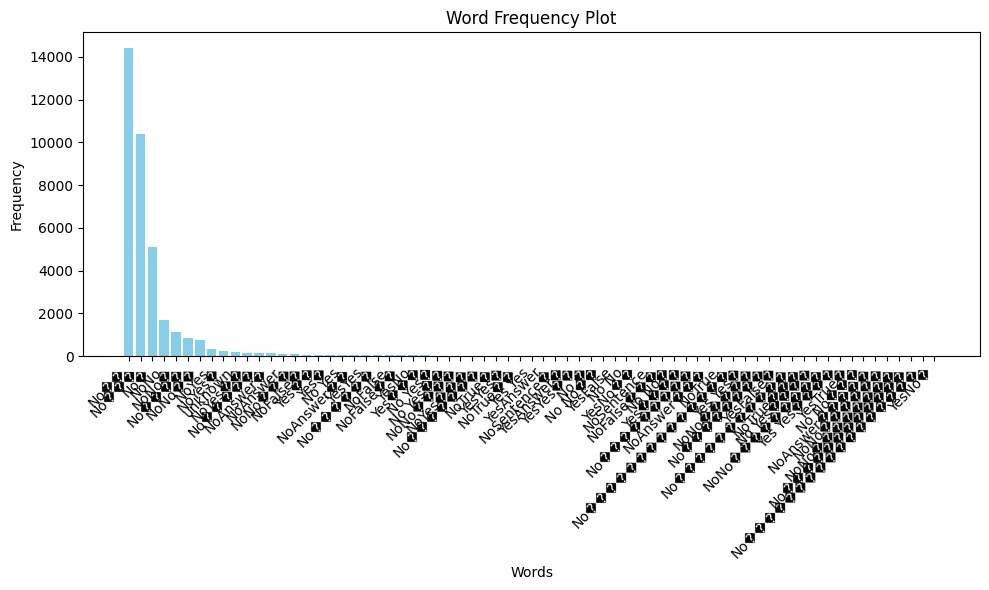

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

word_frequencies = Counter(responses)

# Extract words and their frequencies
words, frequencies = zip(*word_frequencies.most_common())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Plot')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [19]:
y_pred = [1 if "yes" in word.lower() else 0 for word in responses]
print(Counter(y_pred))

Counter({0: 35310, 1: 1128})


In [20]:
print(Counter(dev_answer))

Counter({0: 33173, 1: 3265})


In [21]:
evaluation(y_pred, dev_answer)

Confusion Matrix: [[32163  1010]
 [ 3147   118]]
Precision: [0.91087511 0.10460993]
Recall: [0.96955355 0.03614089]
F1: [0.9392988  0.05372183]
Support: [33173  3265]
Accuracy: 0.8859158021845326
Macro Precision: 0.5077425176401116
Macro Recall: 0.5028472203981088
Macro F1: 0.4965103171335747


**test**

In [17]:
model.eval()
testset = test_data_with_prompt

responses = []

for i in tqdm(range(0, len(testset), batch_size), desc="Processing", unit="batch"):
    batch = testset[i:i + batch_size]
    inputs = tokenizer(
        batch,
        return_tensors="pt",  # Ensure output is in tensor format
        padding=True,
        truncation=True,
        max_length=256,
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            do_sample=False
        )

    predictions = np.argmax(output[0].cpu(), axis=-1)
    generated_text = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    for text in generated_text:
        if "Answer:" in text:
            response = text.split("Answer:")[1].strip()
            responses.append(response)
        else:
            responses.append("unknown") 

Processing: 100%|██████████| 1343/1343 [1:28:05<00:00,  3.94s/batch]


In [20]:
from collections import Counter
import matplotlib.pyplot as plt

word_frequencies = Counter(responses)

# Extract words and their frequencies
words, frequencies = zip(*word_frequencies.most_common())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Plot')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

NameError: name 'responses' is not defined

In [25]:
y_pred = [1 if "yes" in word.lower() and "no" not in word.lower() else 0 for word in responses]
print(Counter(y_pred))

Counter({0: 41645, 1: 1303})


In [26]:
print(Counter(test_answer))

Counter({0: 39106, 1: 3842})


In [27]:
evaluation(y_pred, test_answer)

Confusion Matrix: [[37936  1170]
 [ 3709   133]]
Precision: [0.91093769 0.10207214]
Recall: [0.97008132 0.03461739]
F1: [0.9395797  0.05170068]
Support: [39106  3842]
Accuracy: 0.8863975039582751
Macro Precision: 0.5065049144050685
Macro Recall: 0.5023493521113066
Macro F1: 0.4956401879397968
